In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import cPickle as pickle
import time
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from engine.simulator import FleetSimulator
from engine.lp import Agent
import experiment as ex
plt.style.use('ggplot')

In [2]:
GRAPH_PATH = 'data/pickle/nyc_network_graph.pkl'
TRIP_PATH = 'data/nyc_taxi/trips_2016-05.csv'
DEMAND_MODEL_PATH = 'data/pickle/demand_predictor.pkl'
ETA_MODEL_PATH = 'data/pickle/triptime_predictor.pkl'
GEOHASH_TABLE_PATH = 'data/table/zones.csv'
ETA_TABLE_PATH = 'data/table/eta.csv'
PDEST_TABLE_PATH = 'data/table/pdest.csv'
SCORE_PATH = 'data/results/score_lp.csv'

SAMPLE_SIZE = 500000
NUM_FLEETS = 8000
NO_OP_STEPS = 1
CYCLE = 15

In [3]:
with open(GRAPH_PATH, 'r') as f:
    G = pickle.load(f)
with open(ETA_MODEL_PATH, 'r') as f:
    eta_model = pickle.load(f)
with open(DEMAND_MODEL_PATH, 'r') as f:
    demand_model = pickle.load(f)

geohash_table = pd.read_csv(GEOHASH_TABLE_PATH, index_col='geohash')
eta_table = pd.read_csv(ETA_TABLE_PATH, index_col=['dayofweek', 'hour', 'pickup_zone'])
pdest_table = pd.read_csv(PDEST_TABLE_PATH, index_col=['dayofweek', 'hour', 'pickup_zone'])

In [4]:
trips, dayofweek, minofday, duration = ex.load_trips(TRIP_PATH, SAMPLE_SIZE)
env = FleetSimulator(G, eta_model, CYCLE)
num_steps = 1440 / CYCLE

In [7]:
%%time
env.reset(NUM_FLEETS, trips, dayofweek, minofday)    
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
score = ex.run(env, None, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (12 elapsed) // REQ: 32455 / REJ: 3919 / AWT: 4.6 / DSP: 0.0 / RWD: 86.0
t = 120 (9 elapsed) // REQ: 28297 / REJ: 5438 / AWT: 5.4 / DSP: 0.0 / RWD: 40.6
t = 180 (8 elapsed) // REQ: 22625 / REJ: 4640 / AWT: 5.7 / DSP: 0.0 / RWD: 30.1
t = 240 (7 elapsed) // REQ: 17120 / REJ: 3448 / AWT: 5.5 / DSP: 0.0 / RWD: 21.8
t = 300 (4 elapsed) // REQ: 8489 / REJ: 462 / AWT: 4.4 / DSP: 0.0 / RWD: 12.3
t = 360 (4 elapsed) // REQ: 4982 / REJ: 826 / AWT: 6.6 / DSP: 0.0 / RWD: 8.3
t = 420 (5 elapsed) // REQ: 6003 / REJ: 1335 / AWT: 7.0 / DSP: 0.0 / RWD: 9.7
t = 480 (6 elapsed) // REQ: 8639 / REJ: 2661 / AWT: 7.2 / DSP: 0.0 / RWD: 13.2
t = 540 (7 elapsed) // REQ: 13086 / REJ: 4686 / AWT: 6.7 / DSP: 0.0 / RWD: 19.3
t = 600 (9 elapsed) // REQ: 19045 / REJ: 7354 / AWT: 5.8 / DSP: 0.0 / RWD: 26.6
t = 660 (10 elapsed) // REQ: 24819 / REJ: 8737 / AWT: 4.9 / DSP: 0.0 / RWD: 34.3
t = 720 (10 elapsed) // REQ: 28479 / REJ: 9582 / AWT: 4.5 / DSP: 0.0 / RWD: 40.0
t = 780 (10 elapsed) // REQ: 29768 / REJ: 8007

In [8]:
def plot(result):
    index = result.index
    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    plt.ylabel('total_count')
    plt.plot(index, result.requests, label='demand')
    plt.plot(index, result.reject, label='reject')
    plt.plot(index, result.dispatch, label='dispatch')
#     plt.plot(index, result.prediction, label='prediction')
    plt.plot(index, result.resource, label='resource')
    plt.legend()
    plt.subplot(212)
    plt.ylabel('wait time')
    plt.plot(index, result.wait_time/(result.requests-result.reject))
    return plt

In [5]:
env.reset(NUM_FLEETS, trips, dayofweek, minofday)

agent = Agent(geohash_table, eta_table, pdest_table, demand_model, CYCLE,
              T=2, cost=0, penalty=25.0, svv_rate=1.0)
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
agent.reset(requests, env.dayofweek, env.minofday)
score = ex.run(env, agent, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (158 elapsed) // REQ: 32455 / REJ: 3567 / AWT: 4.6 / DSP: 0.13 / RWD: 85.6
t = 120 (125 elapsed) // REQ: 28297 / REJ: 4564 / AWT: 5.4 / DSP: 0.14 / RWD: 41.3
t = 180 (133 elapsed) // REQ: 22625 / REJ: 3481 / AWT: 5.5 / DSP: 0.16 / RWD: 31.2
t = 240 (115 elapsed) // REQ: 17120 / REJ: 2143 / AWT: 5.2 / DSP: 0.15 / RWD: 23.3
t = 300 (121 elapsed) // REQ: 8489 / REJ: 37 / AWT: 2.8 / DSP: 0.15 / RWD: 11.3
t = 360 (108 elapsed) // REQ: 4982 / REJ: 0 / AWT: 3.4 / DSP: 0.13 / RWD: 8.5
t = 420 (120 elapsed) // REQ: 6003 / REJ: 119 / AWT: 4.0 / DSP: 0.14 / RWD: 10.6
t = 480 (113 elapsed) // REQ: 8639 / REJ: 376 / AWT: 5.1 / DSP: 0.15 / RWD: 16.0
t = 540 (107 elapsed) // REQ: 13086 / REJ: 1991 / AWT: 5.6 / DSP: 0.12 / RWD: 23.2
t = 600 (110 elapsed) // REQ: 19045 / REJ: 4798 / AWT: 5.1 / DSP: 0.12 / RWD: 30.6
t = 660 (105 elapsed) // REQ: 24819 / REJ: 6074 / AWT: 4.4 / DSP: 0.09 / RWD: 38.6
t = 720 (104 elapsed) // REQ: 28479 / REJ: 6989 / AWT: 4.1 / DSP: 0.05 / RWD: 44.7
t = 780 (106 elap

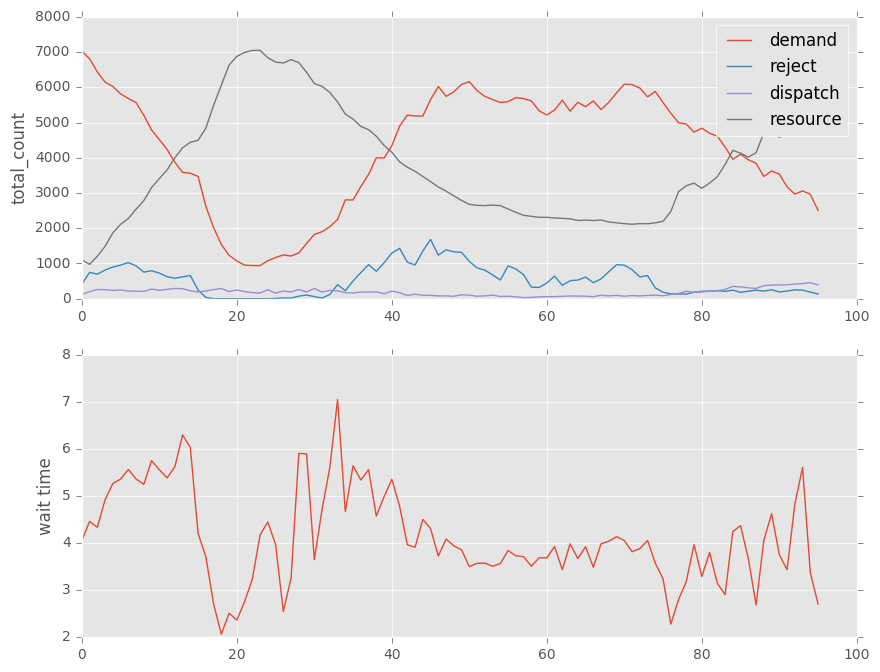

In [9]:
plot(score);

In [10]:
env.reset(NUM_FLEETS, trips, dayofweek, minofday)

agent = Agent(geohash_table, eta_table, pdest_table, demand_model, CYCLE,
              T=3, cost=0, penalty=25.0, svv_rate=1.0)
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
agent.reset(requests, env.dayofweek, env.minofday)
score = ex.run(env, agent, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (289 elapsed) // REQ: 26430 / REJ: 2590 / AWT: 4.4 / DSP: 0.16 / RWD: 75.5
t = 120 (337 elapsed) // REQ: 23090 / REJ: 2584 / AWT: 5.5 / DSP: 0.35 / RWD: 32.8
t = 180 (376 elapsed) // REQ: 18750 / REJ: 441 / AWT: 5.2 / DSP: 0.46 / RWD: 25.3
t = 240 (411 elapsed) // REQ: 14495 / REJ: 0 / AWT: 2.8 / DSP: 0.55 / RWD: 15.6
t = 300 (276 elapsed) // REQ: 7418 / REJ: 0 / AWT: 1.2 / DSP: 0.20 / RWD: 7.0
t = 360 (240 elapsed) // REQ: 3905 / REJ: 0 / AWT: 1.5 / DSP: 0.06 / RWD: 7.7
t = 420 (248 elapsed) // REQ: 4701 / REJ: 0 / AWT: 1.7 / DSP: 0.10 / RWD: 9.2
t = 480 (287 elapsed) // REQ: 6594 / REJ: 0 / AWT: 1.9 / DSP: 0.19 / RWD: 12.7
t = 540 (366 elapsed) // REQ: 9905 / REJ: 0 / AWT: 1.9 / DSP: 0.31 / RWD: 16.6
t = 600 (382 elapsed) // REQ: 14705 / REJ: 0 / AWT: 1.9 / DSP: 0.30 / RWD: 25.9
t = 660 (311 elapsed) // REQ: 19635 / REJ: 0 / AWT: 1.8 / DSP: 0.19 / RWD: 38.1
t = 720 (281 elapsed) // REQ: 22605 / REJ: 0 / AWT: 2.0 / DSP: 0.14 / RWD: 46.3
t = 780 (270 elapsed) // REQ: 24023 / REJ

In [71]:
env.reset(NUM_FLEETS, trips, dayofweek, minofday)

agent = Agent(geohash_table, eta_table, pdest_table, demand_model, CYCLE,
              T=3, cost=0, penalty=25.0, svv_rate=1.0)
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
agent.reset(requests, env.dayofweek, env.minofday)
score = ex.run(env, agent, num_steps, average_cycle=4)
ex.describe(score)

t: 60 / elapsed time 219
REQUESTS: 26430 / REJECTS: 2613 / ACTIONS: 1213 / GAS: 14202 / PRED: 24326
t: 120 / elapsed time 252
REQUESTS: 23090 / REJECTS: 2945 / ACTIONS: 2340 / GAS: 29055 / PRED: 20763
t: 180 / elapsed time 278
REQUESTS: 18750 / REJECTS: 953 / ACTIONS: 3038 / GAS: 39937 / PRED: 17593
t: 240 / elapsed time 290
REQUESTS: 14495 / REJECTS: 6 / ACTIONS: 3354 / GAS: 56438 / PRED: 13856
t: 300 / elapsed time 315
REQUESTS: 7418 / REJECTS: 0 / ACTIONS: 2258 / GAS: 61715 / PRED: 8843
t: 360 / elapsed time 313
REQUESTS: 3905 / REJECTS: 0 / ACTIONS: 480 / GAS: 5585 / PRED: 5979
t: 420 / elapsed time 344
REQUESTS: 4701 / REJECTS: 0 / ACTIONS: 941 / GAS: 11357 / PRED: 6554
t: 480 / elapsed time 427
REQUESTS: 6594 / REJECTS: 0 / ACTIONS: 1931 / GAS: 33417 / PRED: 8560
t: 540 / elapsed time 416
REQUESTS: 9905 / REJECTS: 0 / ACTIONS: 2571 / GAS: 51021 / PRED: 11434
t: 600 / elapsed time 240
REQUESTS: 14705 / REJECTS: 0 / ACTIONS: 1752 / GAS: 33914 / PRED: 14737
t: 660 / elapsed time 213

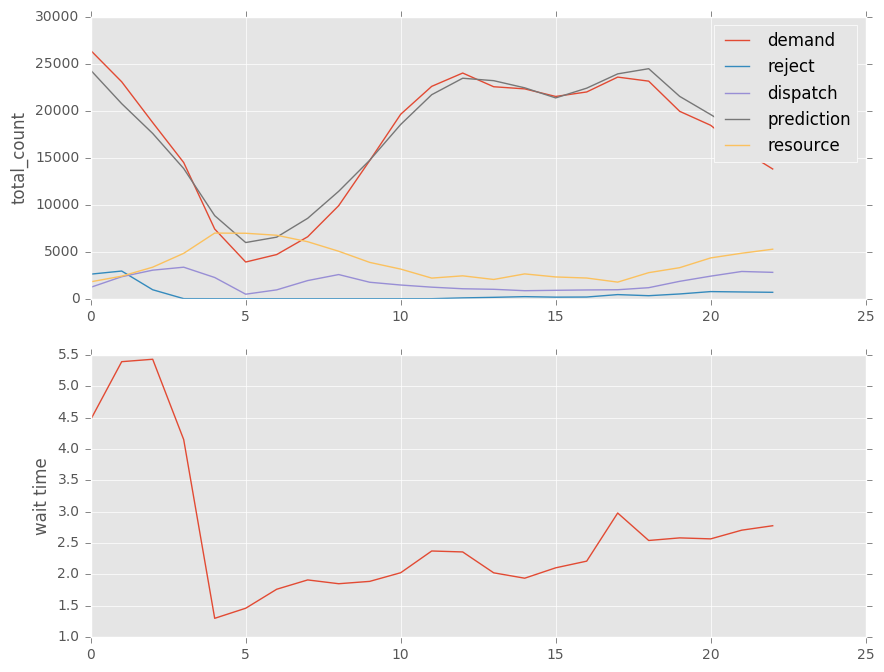

In [72]:
ex.plot(score);

In [21]:
def plot_result(result, reposition_cycle=15):
    plt.figure(figsize=(10, 10))
    plt.subplot(311)
    plt.ylabel('count')
    plt.ylim([0, 100])
    plt.plot(result.index, result.w_z, label='demand')
    plt.plot(result.index, result.reject_z, label='reject')
    plt.plot(result.index, result.u_z, label='reposition')
    plt.plot(result.index, result.wp_z/reposition_cycle, label='prediction')
    plt.plot(result.index, result.x_z, label='vehicle')
    plt.legend()
    plt.subplot(312)
    plt.ylabel('total_count')
    plt.plot(result.index, result.W, label='demand')
    plt.plot(result.index, result.reject, label='reject')
    plt.plot(result.index, result.U, label='reposition')
    plt.plot(result.index, result.Wp/reposition_cycle, label='prediction')
    plt.plot(result.index, result.X/10, label='vehicle/10')
    plt.plot(result.index, result.ST0, label='ST1')
    plt.plot(result.index, result.ST1, label='ST2')
    plt.legend()
    plt.subplot(313)
    plt.ylabel('wait time')
    plt.plot(result.index, result.wait/(result.W-result.reject))
    return plt

## Load dataset and pickles

In [3]:
with open('data/pickle/nyc_network_graph.pkl', 'r') as f:
    G = pickle.load(f)

In [3]:
data_path = 'data/nyc_taxi/trips_2016-05.csv'
dataset = pd.read_csv(data_path, nrows=500000)
dataset = dataset[['trip_time', 'phash', 'plat', 'plon', 'dhash', 'dlat', 'dlon', 'second']]
dayofweek0 = 6
dataset.head()

,trip_time,phash,plat,plon,dhash,dlat,dlon,second
0,17.516667,dr5rumt,40.768249,-73.985475,dr5rsqw,40.729667,-73.983788,0
1,7.016667,dr5ru0z,40.742039,-73.993433,dr5ru92,40.744732,-73.980941,0
2,19.783333,dr5rkq2,40.684367,-73.992064,dr5rsp1,40.732507,-74.001829,0
3,7.516667,dr5ru32,40.745078,-73.992071,dr5ruth,40.765470,-73.975744,0
4,6.650000,dr5rgbx,40.740652,-74.004656,dr5ru0h,40.737793,-73.997871,0


In [4]:
with open('data/pickle/demand_predictor.pkl', 'r') as f:
    demand_model = pickle.load(f)

In [5]:
with open('data/pickle/triptime_predictor.pkl', 'r') as f:
    eta_model = pickle.load(f)

Using TensorFlow backend.


In [7]:
from simulator import FleetSimulator
from agent import Agent

In [8]:
import time

def run(simulator, agent, T, N=3, reposition_cycle=15, taxi_zone=78, nStorage=2, verbose=True):
    vehicles, requests, reward = simulator.forward()    
    result = np.zeros((T, 13+nStorage))
    hash_in_zone = agent.state[agent.state.taxi_zone==taxi_zone].index
    start = time.time()
    carry_in_cost = 0

    for t in range(T):
        if t % 60 == 0 and verbose:
            elapsed_time = time.time() - start
            print "hour %d: elapsed %d" % (t/60.0, elapsed_time)
            start = time.time()

        assignments = agent.match(vehicles, requests)
        vehicles, wait, reject = simulator.assign(assignments)
        X = sum(vehicles.available)
        W = len(requests)
        x_z = sum([1 for g in vehicles[vehicles.available==1]['geohash'].values if g in hash_in_zone])  
        w_z = sum([1 for g in requests['phash'].values if g in hash_in_zone])
        reject_z = w_z - sum([1 for g in requests.loc[[i for i, _ in assignments], 'phash'] if g in hash_in_zone])
        
        if t > 0 and t % reposition_cycle == 0:
            actions, carry_in, carry_out, state, objective = agent.reposition(vehicles, T=N)
            Wp = state.W.sum()
            wp_z = state.loc[taxi_zone, 'W']
            U = len(actions)
            u_z = state.loc[taxi_zone, 'flow']
            simulator.reposition(actions)
            carry_in_cost, storage_state = simulator.carry_in(carry_in)
            simulator.carry_out(carry_out)
            if verbose:
                print "t: %d\t total_flow: %d\t carry_in: %d\t carry_out: %d\t objective: %d" % (
                    t, U,  len(carry_in),  len(carry_out), objective)

        vehicles, requests, cost = simulator.forward()
        if t >= 15:
            result[int(t-15), :8] = (t/60.0, X, W, wait, reject, x_z, w_z, reject_z)
            if t >= reposition_cycle:
                result[int(t-15), 8:13] = (cost+carry_in_cost, Wp, U, wp_z, u_z)                
                if nStorage > 0:
                    result[int(t-15), 13:] = storage_state

    result = pd.DataFrame(result, columns=[
        'hour', 'X', 'W', 'wait', 'reject', 'x_z', 'w_z', 'reject_z', 'cost', 'Wp', 'U',
        'wp_z', 'u_z'] + ['ST'+str(s) for s in range(nStorage)]
    )    
    print "Total requests: %d" % result.W.sum()
    print "Total rejects: %d" % result.reject.sum()
    print "Total cost: %d" % result.cost.sum()
    print "Mean wait time: %.2f" % (result.wait.sum()/(result.W.sum()-result.reject.sum()))

    return result

In [9]:
def summary(result):
    print result.W.sum()
    print result.reject.sum()
    print result.cost.sum()
    print (result.wait.sum()/(result.W.sum()-result.reject.sum()))

In [21]:
def plot_result(result, reposition_cycle=15):
    plt.figure(figsize=(10, 10))
    plt.subplot(311)
    plt.ylabel('count')
    plt.ylim([0, 100])
    plt.plot(result.index, result.w_z, label='demand')
    plt.plot(result.index, result.reject_z, label='reject')
    plt.plot(result.index, result.u_z, label='reposition')
    plt.plot(result.index, result.wp_z/reposition_cycle, label='prediction')
    plt.plot(result.index, result.x_z, label='vehicle')
    plt.legend()
    plt.subplot(312)
    plt.ylabel('total_count')
    plt.plot(result.index, result.W, label='demand')
    plt.plot(result.index, result.reject, label='reject')
    plt.plot(result.index, result.U, label='reposition')
    plt.plot(result.index, result.Wp/reposition_cycle, label='prediction')
    plt.plot(result.index, result.X/10, label='vehicle/10')
    plt.plot(result.index, result.ST0, label='ST1')
    plt.plot(result.index, result.ST1, label='ST2')
    plt.legend()
    plt.subplot(313)
    plt.ylabel('wait time')
    plt.plot(result.index, result.wait/(result.W-result.reject))
    return plt

In [11]:
storage =pd.DataFrame(columns=['lat', 'lon', 'zone', 'capacity', 'cost', 'carry_out_time'])
storage

,lat,lon,zone,capacity,cost,carry_out_time


## Setup simulator and agent

In [19]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)
simulator.init_storage(storage)

geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, storage, dayofweek=dayofweek0)

In [20]:
%%time
result = run(simulator, agent, T=60*24, reposition_cycle=1e10)

hour 0: elapsed 0
hour 1: elapsed 16
hour 2: elapsed 14
hour 3: elapsed 13
hour 4: elapsed 12
hour 5: elapsed 10
hour 6: elapsed 8
hour 7: elapsed 8
hour 8: elapsed 9
hour 9: elapsed 10
hour 10: elapsed 12
hour 11: elapsed 13
hour 12: elapsed 14
hour 13: elapsed 14
hour 14: elapsed 13
hour 15: elapsed 13
hour 16: elapsed 13
hour 17: elapsed 13
hour 18: elapsed 13
hour 19: elapsed 13
hour 20: elapsed 12
hour 21: elapsed 12
hour 22: elapsed 11
hour 23: elapsed 11
Total requests: 408779
Total rejects: 83180
Total cost: 0
Mean wait time: 4.28
CPU times: user 4min 19s, sys: 38.7 s, total: 4min 58s
Wall time: 4min 57s


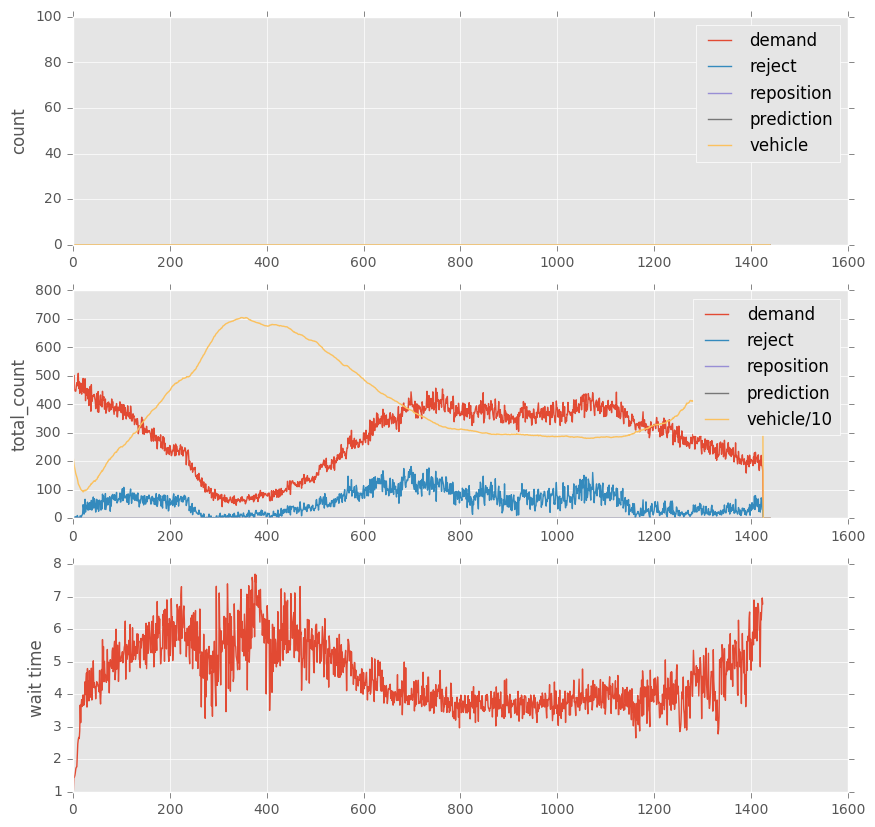

In [21]:
plot_result(result);

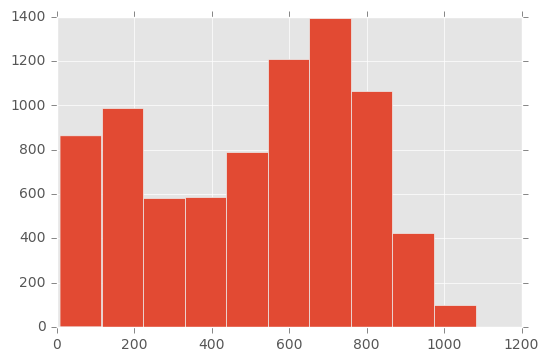

In [22]:
vrecords = simulator.get_vehicles_record()
vrecords.total_service_time.hist();

In [23]:
# from mapper.geohelper import plot_overmap

# shape_file_path = "../analytics/data/taxi_zones/taxi_zones.shp"
# vehicles, requests, reward = simulator.forward()    
# point_y = vehicles[vehicles.available==1].lat.values
# point_x = vehicles[vehicles.available==1].lon.values
# radius=0.001
# plot_overmap(point_x, point_y, radius, shape_file_path)

## Linear Programming Policy

In [12]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)
simulator.init_storage(storage)

rcycle = 15
tmax = 25
rcost = 1
penalty = 25.0
svv_rate = 0.9
saving = 5.0
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, storage, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost,
              reject_penalty=penalty, svv_rate=svv_rate, storage_saving=saving)

In [13]:
result = run(simulator, agent, T=60*24, N=2, reposition_cycle=rcycle, nStorage=0)

hour 0: elapsed 0


/Users/odatakuma/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1160: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  result = getitem(key)
/Users/odatakuma/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


t: 15	 total_flow: 15	 carry_in: 0	 carry_out: 0	 objective: 106190
t: 30	 total_flow: 104	 carry_in: 0	 carry_out: 0	 objective: 137337
t: 45	 total_flow: 110	 carry_in: 0	 carry_out: 0	 objective: 157977
hour 1: elapsed 58
t: 60	 total_flow: 104	 carry_in: 0	 carry_out: 0	 objective: 162768
t: 75	 total_flow: 50	 carry_in: 0	 carry_out: 0	 objective: 164010
t: 90	 total_flow: 59	 carry_in: 0	 carry_out: 0	 objective: 151915
t: 105	 total_flow: 39	 carry_in: 0	 carry_out: 0	 objective: 153289
hour 2: elapsed 74
t: 120	 total_flow: 53	 carry_in: 0	 carry_out: 0	 objective: 152327
t: 135	 total_flow: 36	 carry_in: 0	 carry_out: 0	 objective: 153310
t: 150	 total_flow: 26	 carry_in: 0	 carry_out: 0	 objective: 134638
t: 165	 total_flow: 58	 carry_in: 0	 carry_out: 0	 objective: 129158
hour 3: elapsed 75
t: 180	 total_flow: 89	 carry_in: 0	 carry_out: 0	 objective: 122891
t: 195	 total_flow: 96	 carry_in: 0	 carry_out: 0	 objective: 116838
t: 210	 total_flow: 67	 carry_in: 0	 carry_out: 0

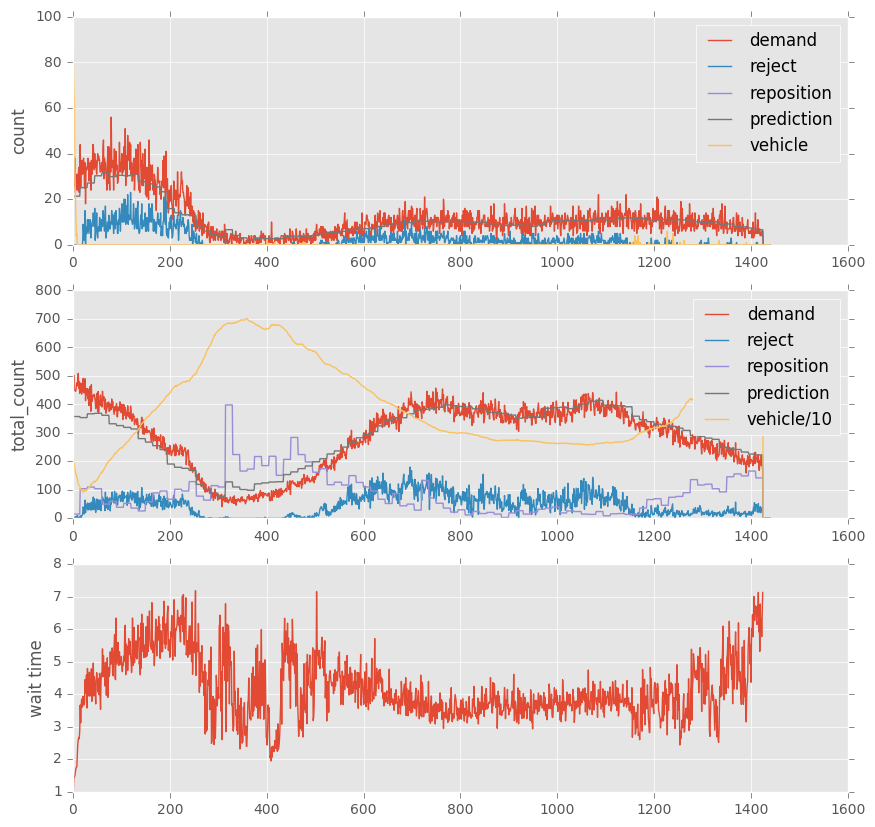

In [14]:
plot_result(result, reposition_cycle=rcycle);

In [11]:
import Geohash

geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
storage =pd.DataFrame(columns=['lat', 'lon', 'zone', 'capacity', 'cost', 'carry_out_time'])
slocs = [(40.715714, -74.013488), (40.810477, -73.908797)]
for i, (lat, lon) in enumerate(slocs):
    g = Geohash.encode(lat, lon, precision=7)
    zone = geohash_table.loc[g, 'taxi_zone'].astype(int)
    zones = list(geohash_table.taxi_zone.unique())
    zones.sort()
    zone = zones.index(zone)
    storage.loc[i] = lat, lon, zone, 4000, 5, 15
storage

,lat,lon,zone,capacity,cost,carry_out_time
0,40.715714,-74.013488,190,4000,5,15
1,40.810477,-73.908797,138,4000,5,15


In [17]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)
simulator.init_storage(storage)

rcycle = 15
tmax = 25
rcost = 1
penalty = 25.0
svv_rate = 0.9
saving = 5.0
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, storage, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost,
              reject_penalty=penalty, svv_rate=svv_rate, storage_saving=saving)

In [18]:
result = run(simulator, agent, T=60*24, N=3, reposition_cycle=rcycle, nStorage=2)

hour 0: elapsed 0


/Users/odatakuma/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1149: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


t: 15	 total_flow: 13	 carry_in: 2	 carry_out: 0	 objective: 152195
t: 30	 total_flow: 174	 carry_in: 6	 carry_out: 0	 objective: 186545
t: 45	 total_flow: 265	 carry_in: 9	 carry_out: 0	 objective: 207784
hour 1: elapsed 197
t: 60	 total_flow: 354	 carry_in: 8	 carry_out: 0	 objective: 214381
t: 75	 total_flow: 389	 carry_in: 8	 carry_out: 0	 objective: 212762
t: 90	 total_flow: 519	 carry_in: 7	 carry_out: 0	 objective: 192358
t: 105	 total_flow: 493	 carry_in: 9	 carry_out: 0	 objective: 190364
hour 2: elapsed 211
t: 120	 total_flow: 499	 carry_in: 12	 carry_out: 0	 objective: 186609
t: 135	 total_flow: 583	 carry_in: 6	 carry_out: 0	 objective: 184772
t: 150	 total_flow: 576	 carry_in: 8	 carry_out: 0	 objective: 157150
t: 165	 total_flow: 582	 carry_in: 7	 carry_out: 0	 objective: 147504
hour 3: elapsed 225
t: 180	 total_flow: 650	 carry_in: 8	 carry_out: 0	 objective: 140200
t: 195	 total_flow: 666	 carry_in: 4	 carry_out: 0	 objective: 130213
t: 210	 total_flow: 693	 carry_in: 0

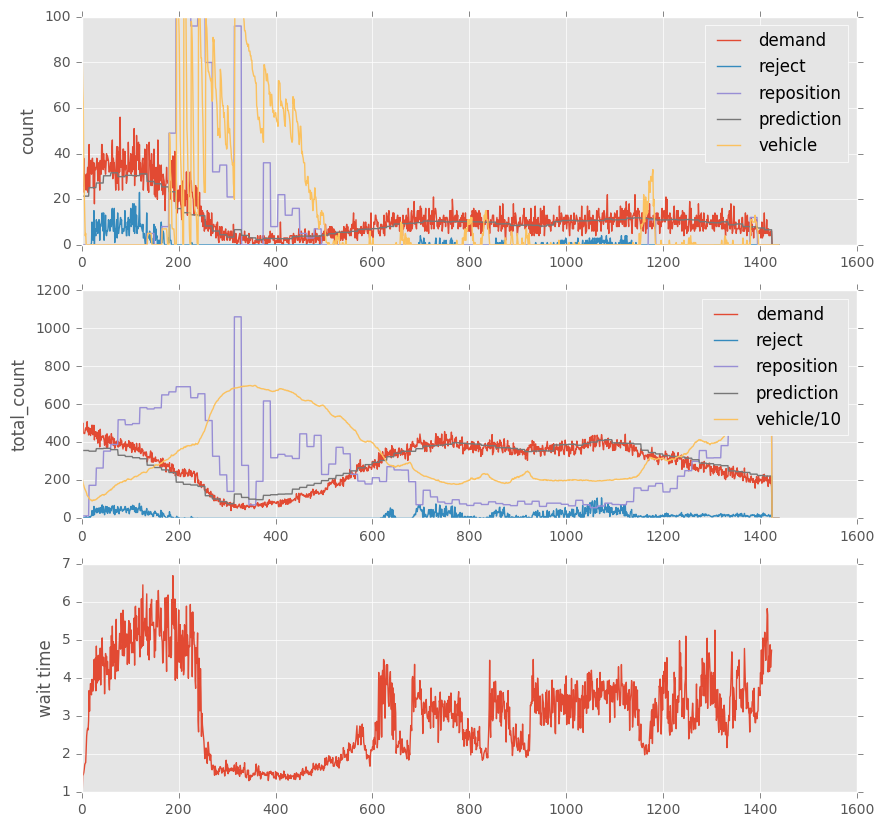

In [19]:
plot_result(result, reposition_cycle=rcycle);

In [20]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)
simulator.init_storage(storage)

rcycle = 20
tmax = 25
rcost = 1
penalty = 40.0
svv_rate = 0.9
saving = 5.0
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, storage, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost,
              reject_penalty=penalty, svv_rate=svv_rate, storage_saving=saving)

In [21]:
result = run(simulator, agent, T=60*24, N=3, reposition_cycle=rcycle, nStorage=2)

hour 0: elapsed 0
t: 20	 total_flow: 19	 carry_in: 0	 carry_out: 0	 objective: 430273
t: 40	 total_flow: 261	 carry_in: 0	 carry_out: 0	 objective: 475429
hour 1: elapsed 99
t: 60	 total_flow: 494	 carry_in: 0	 carry_out: 0	 objective: 492287
t: 80	 total_flow: 677	 carry_in: 0	 carry_out: 0	 objective: 480884
t: 100	 total_flow: 812	 carry_in: 0	 carry_out: 0	 objective: 422360
hour 2: elapsed 203
t: 120	 total_flow: 809	 carry_in: 0	 carry_out: 0	 objective: 407542
t: 140	 total_flow: 904	 carry_in: 0	 carry_out: 0	 objective: 391780
t: 160	 total_flow: 1067	 carry_in: 0	 carry_out: 0	 objective: 320212
hour 3: elapsed 254
t: 180	 total_flow: 1235	 carry_in: 0	 carry_out: 0	 objective: 290745
t: 200	 total_flow: 1400	 carry_in: 0	 carry_out: 0	 objective: 248562
t: 220	 total_flow: 1401	 carry_in: 0	 carry_out: 0	 objective: 135057
hour 4: elapsed 310
t: 240	 total_flow: 1269	 carry_in: 0	 carry_out: 0	 objective: 123503
t: 260	 total_flow: 1311	 carry_in: 0	 carry_out: 0	 objective:

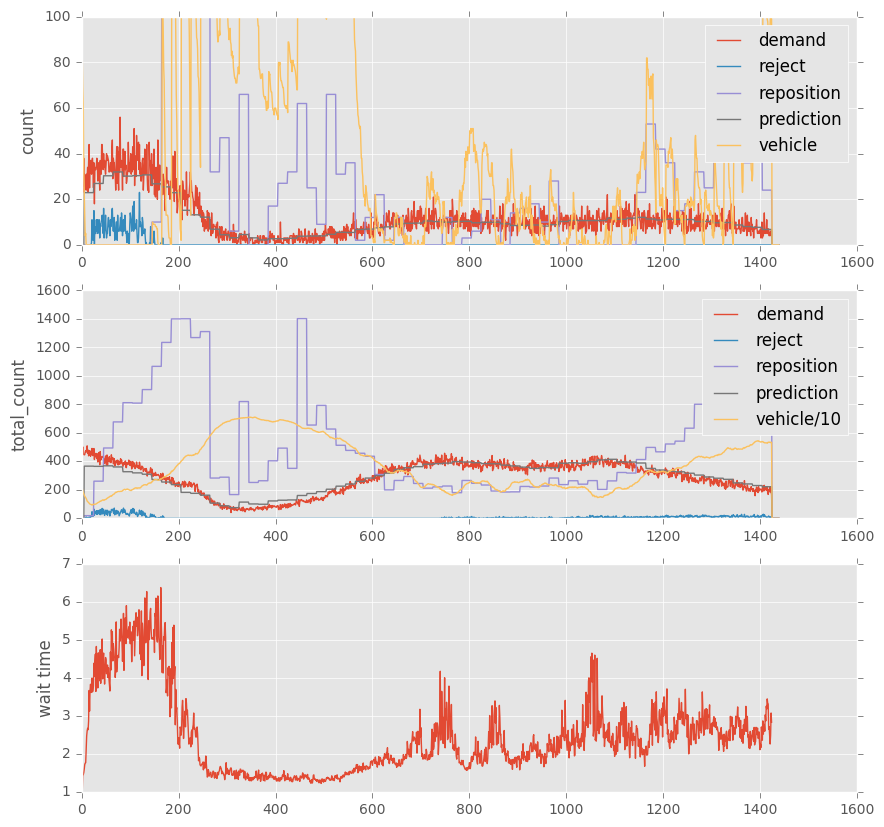

In [22]:
plot_result(result, reposition_cycle=rcycle);

In [23]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)
simulator.init_storage(storage)

rcycle = 15
tmax = 25
rcost = 1
penalty = 40.0
svv_rate = 0.8
saving = 5.0
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, storage, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost,
              reject_penalty=penalty, svv_rate=svv_rate, storage_saving=saving)

In [24]:
result = run(simulator, agent, T=60*12, N=4, reposition_cycle=rcycle, nStorage=2)

hour 0: elapsed 0
t: 15	 total_flow: 16	 carry_in: 0	 carry_out: 0	 objective: 312074
t: 30	 total_flow: 217	 carry_in: 0	 carry_out: 0	 objective: 366458
t: 45	 total_flow: 321	 carry_in: 0	 carry_out: 0	 objective: 405657
hour 1: elapsed 251
t: 60	 total_flow: 485	 carry_in: 0	 carry_out: 0	 objective: 416656
t: 75	 total_flow: 574	 carry_in: 0	 carry_out: 0	 objective: 408041
t: 90	 total_flow: 773	 carry_in: 0	 carry_out: 0	 objective: 358834
t: 105	 total_flow: 750	 carry_in: 0	 carry_out: 0	 objective: 349413
hour 2: elapsed 395
t: 120	 total_flow: 800	 carry_in: 0	 carry_out: 0	 objective: 337934
t: 135	 total_flow: 876	 carry_in: 0	 carry_out: 0	 objective: 333023
t: 150	 total_flow: 976	 carry_in: 0	 carry_out: 0	 objective: 274185
t: 165	 total_flow: 1100	 carry_in: 0	 carry_out: 0	 objective: 249946
hour 3: elapsed 493
t: 180	 total_flow: 1225	 carry_in: 0	 carry_out: 0	 objective: 225632
t: 195	 total_flow: 1404	 carry_in: 0	 carry_out: 0	 objective: 194733
t: 210	 total_fl

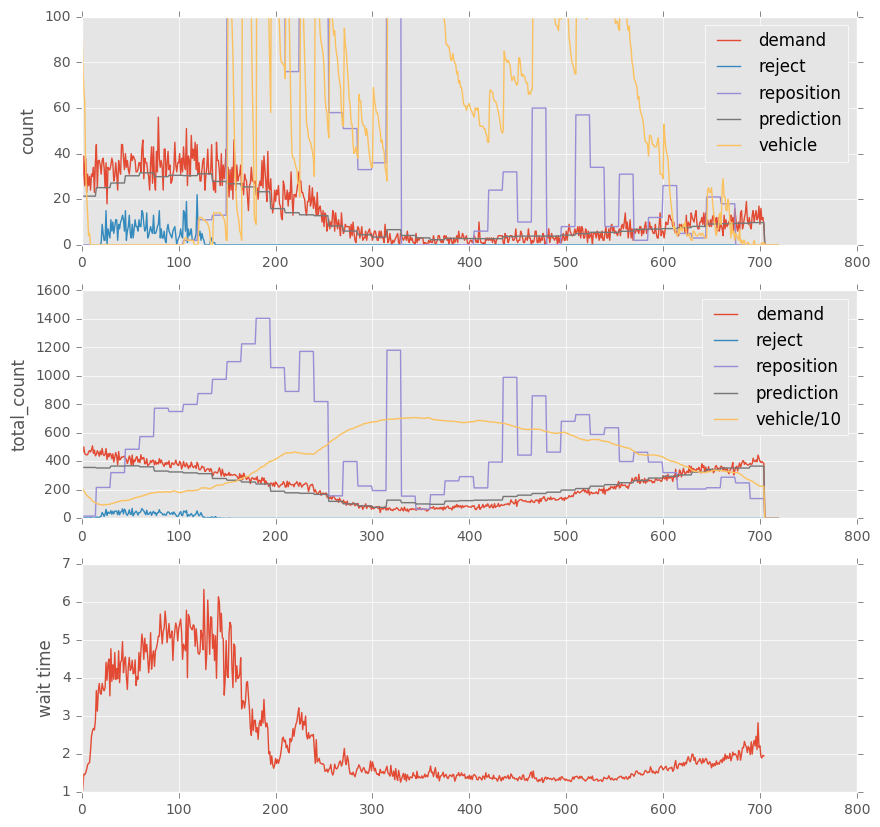

In [25]:
plot_result(result, reposition_cycle=rcycle);

In [26]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)
simulator.init_storage(storage)

rcycle = 15
tmax = 25
rcost = 1
penalty = 40.0
svv_rate = 0.8
saving = 10.0
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, storage, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost,
              reject_penalty=penalty, svv_rate=svv_rate, storage_saving=saving)

In [27]:
result = run(simulator, agent, T=60*12, N=4, reposition_cycle=rcycle, nStorage=2)

hour 0: elapsed 0
t: 15	 total_flow: 16	 carry_in: 2	 carry_out: 0	 objective: 311838
t: 30	 total_flow: 213	 carry_in: 6	 carry_out: 0	 objective: 366124
t: 45	 total_flow: 319	 carry_in: 9	 carry_out: 0	 objective: 405379
hour 1: elapsed 232
t: 60	 total_flow: 474	 carry_in: 9	 carry_out: 0	 objective: 416064
t: 75	 total_flow: 554	 carry_in: 8	 carry_out: 0	 objective: 407322
t: 90	 total_flow: 757	 carry_in: 7	 carry_out: 0	 objective: 358399
t: 105	 total_flow: 727	 carry_in: 9	 carry_out: 0	 objective: 348417
hour 2: elapsed 388
t: 120	 total_flow: 778	 carry_in: 13	 carry_out: 0	 objective: 337140
t: 135	 total_flow: 846	 carry_in: 7	 carry_out: 0	 objective: 332579
t: 150	 total_flow: 922	 carry_in: 8	 carry_out: 0	 objective: 273490
t: 165	 total_flow: 1055	 carry_in: 8	 carry_out: 0	 objective: 250746
hour 3: elapsed 447
t: 180	 total_flow: 1152	 carry_in: 7	 carry_out: 0	 objective: 225842
t: 195	 total_flow: 1397	 carry_in: 4	 carry_out: 0	 objective: 196548
t: 210	 total_f

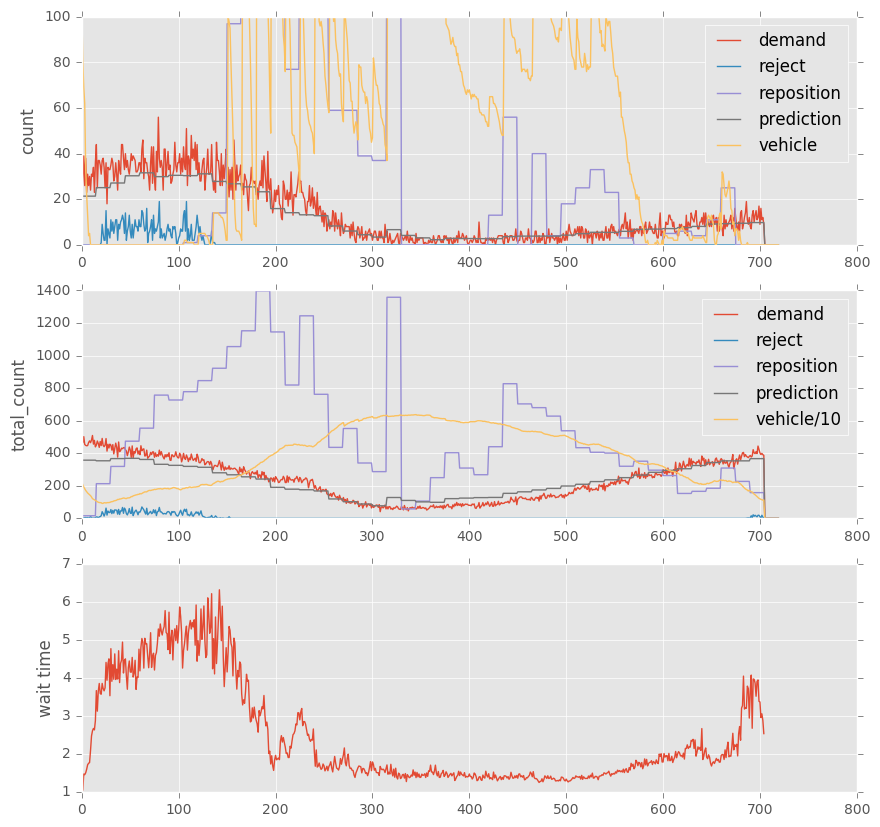

In [28]:
plot_result(result, reposition_cycle=rcycle);

In [23]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)
simulator.init_storage(storage)

rcycle = 15
tmax = 25
rcost = 1
penalty = 40.0
svv_rate = 0.8
saving = 15.0
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, storage, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost,
              reject_penalty=penalty, svv_rate=svv_rate, storage_saving=saving)

result = run(simulator, agent, T=60*24, N=4, reposition_cycle=rcycle, nStorage=2)

hour 0: elapsed 0
t: 15	 total_flow: 16	 carry_in: 2	 carry_out: 0	 objective: 311559
t: 30	 total_flow: 215	 carry_in: 6	 carry_out: 0	 objective: 365699
t: 45	 total_flow: 320	 carry_in: 9	 carry_out: 0	 objective: 404788
hour 1: elapsed 243
t: 60	 total_flow: 484	 carry_in: 10	 carry_out: 0	 objective: 415373
t: 75	 total_flow: 548	 carry_in: 8	 carry_out: 0	 objective: 406002
t: 90	 total_flow: 745	 carry_in: 7	 carry_out: 0	 objective: 357439
t: 105	 total_flow: 741	 carry_in: 9	 carry_out: 0	 objective: 347658
hour 2: elapsed 393
t: 120	 total_flow: 769	 carry_in: 13	 carry_out: 0	 objective: 336104
t: 135	 total_flow: 855	 carry_in: 6	 carry_out: 0	 objective: 330955
t: 150	 total_flow: 941	 carry_in: 8	 carry_out: 0	 objective: 271842
t: 165	 total_flow: 1058	 carry_in: 8	 carry_out: 0	 objective: 248354
hour 3: elapsed 467
t: 180	 total_flow: 1167	 carry_in: 7	 carry_out: 0	 objective: 224255
t: 195	 total_flow: 1370	 carry_in: 4	 carry_out: 0	 objective: 193601
t: 210	 total_

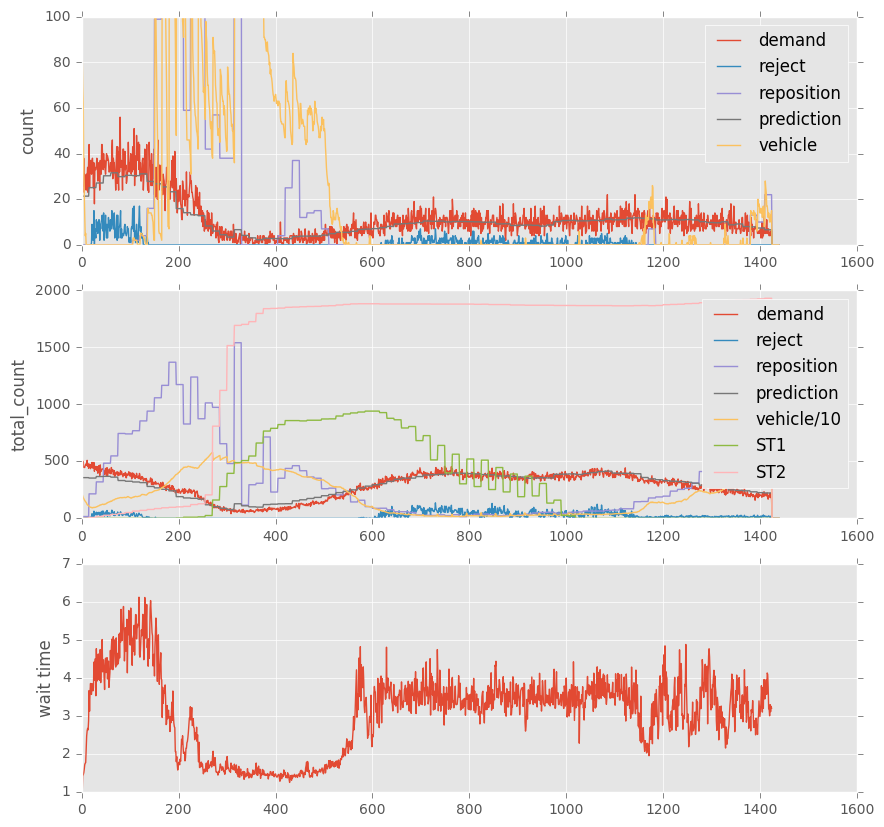

In [24]:
plot_result(result, reposition_cycle=rcycle);

In [15]:
simulator = FleetSimulator(G, dataset, dayofweek=dayofweek0)
simulator.init_vehicles(8000)
simulator.init_storage(storage)

rcycle = 15
tmax = 25
rcost = 1
penalty = 40.0
svv_rate = 0.8
saving = 15.0
geohash_table = pd.read_csv('data/zones.csv', index_col='geohash')
agent = Agent(demand_model, eta_model, pdest_model, geohash_table, storage, dayofweek=dayofweek0,
             reposition_cycle=rcycle, reposition_triptime_max=tmax, reposition_cost=rcost,
              reject_penalty=penalty, svv_rate=svv_rate, storage_saving=saving)

result = run(simulator, agent, T=60*24, N=4, reposition_cycle=rcycle, nStorage=2)

hour 0: elapsed 0
t: 15	 total_flow: 17	 carry_in: 2	 carry_out: 0	 objective: 337427
t: 30	 total_flow: 195	 carry_in: 6	 carry_out: 0	 objective: 391864
t: 45	 total_flow: 255	 carry_in: 9	 carry_out: 0	 objective: 434892
hour 1: elapsed 228
t: 60	 total_flow: 398	 carry_in: 9	 carry_out: 0	 objective: 447718
t: 75	 total_flow: 426	 carry_in: 7	 carry_out: 0	 objective: 439945
t: 90	 total_flow: 523	 carry_in: 7	 carry_out: 0	 objective: 389355
t: 105	 total_flow: 473	 carry_in: 8	 carry_out: 0	 objective: 381966
hour 2: elapsed 362
t: 120	 total_flow: 490	 carry_in: 13	 carry_out: 0	 objective: 373469
t: 135	 total_flow: 538	 carry_in: 10	 carry_out: 0	 objective: 368719
t: 150	 total_flow: 562	 carry_in: 8	 carry_out: 0	 objective: 304025
t: 165	 total_flow: 639	 carry_in: 7	 carry_out: 0	 objective: 283065
hour 3: elapsed 380
t: 180	 total_flow: 703	 carry_in: 21	 carry_out: 0	 objective: 263721
t: 195	 total_flow: 658	 carry_in: 5	 carry_out: 0	 objective: 239575
t: 210	 total_fl

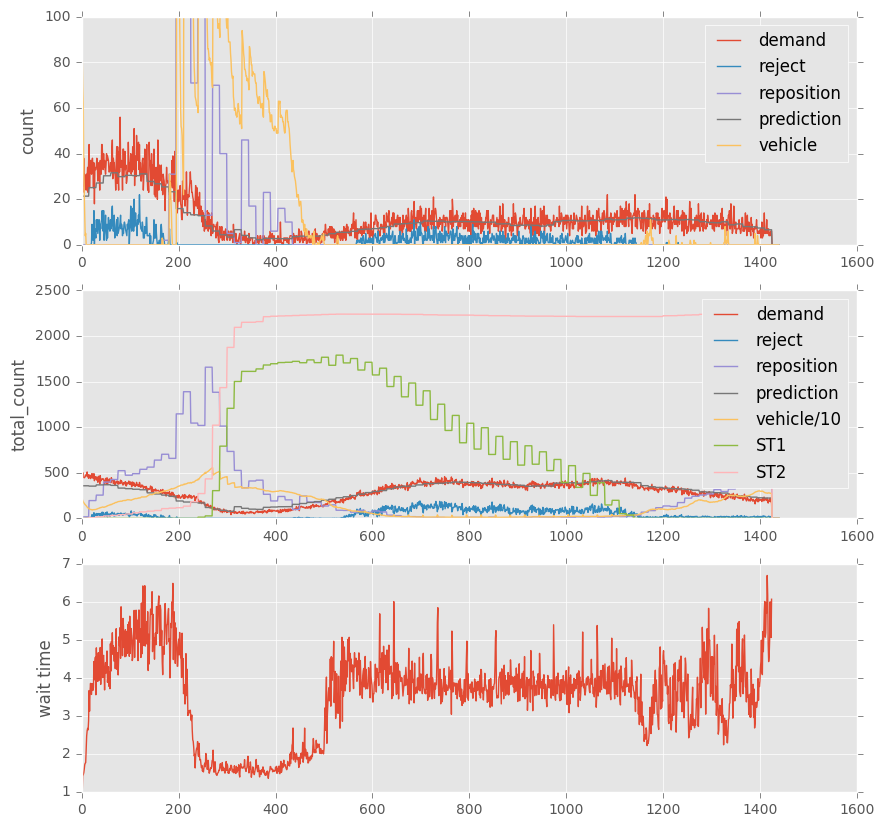

In [22]:
plot_result(result, reposition_cycle=rcycle);